In [1]:
# install libs
!pip install transformers datasets torch numpy pandas wordninja

     |████████████████████████████████| 3.1 MB 9.9 MB/s            
     |████████████████████████████████| 298 kB 16.1 MB/s            
     |████████████████████████████████| 541 kB 17.2 MB/s            
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 61 kB 3.8 MB/s             
     |████████████████████████████████| 124 kB 13.2 MB/s            
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     |████████████████████████████████| 895 kB 15.0 MB/s            
     |████████████████████████████████| 212 kB 12.5 MB/s            
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     |████████████████████████████████| 279 kB 10.6 MB/s            
     |████████████████████████████████| 76 kB 9.7 MB/s             
     |████████████████████████████████| 86 kB 11.3 MB/s            
   

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# download tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [5]:
# helper for cleaning text data
def clean(row):
    text = row['cr_text']
    if text != None and len(text) > 0:
        return text.split('Initial / Intake Allegation ')[1].replace('\n', ' ')
    return ''

In [9]:
data = pd.read_csv('cp5_regress_table.csv')
# clean up the data by taking only the first allegation (due to length constraints)
# and removing the newlines embedded within each cr_text
data['cleaned_text'] = data.apply(lambda row: clean(row), axis=1)

In [10]:
# count and verify that token length falls within 512 tokens
token_lens = []
maxlen = 0
for txt in data.cleaned_text:
    if txt:
        tokens = tokenizer.encode(txt, add_special_tokens=True)
        token_lens.append(len(tokens))
        maxlen = max(maxlen, len(tokens))

print(f"MAX LENGTH: {maxlen}")

data['token_len'] = token_lens

# we have 2 outliers, filter those out
data = data[data['token_len'] < 512]

MAX LENGTH: 611


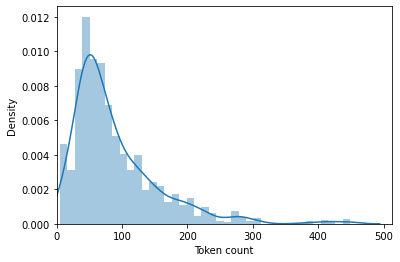

In [11]:
sns.distplot(data['token_len'])
plt.xlim([0, 512]);
plt.xlabel('Token count');

In [12]:
import math
from transformers import pipeline

# download pre-trained sentiment analyzer
# this is the model we will use to generate our sentiment score
sa = pipeline('sentiment-analysis')

def sentiment_score(txt):
    sentiment = sa(txt)[0]
    negative = sentiment['label'] == 'NEGATIVE'
    score = math.log(1 - sentiment['score'])
    return round(score, 2) * (1 if negative else -1)

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/255M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

In [ ]:
# generate sentiment scores
scores = []
for idx, txt in enumerate(data.cleaned_text):
    if txt:
        print(f"{idx}", end=' ')
        if (idx+1) % 10 == 0:
            print("")
        scores.append(sentiment_score(txt))
print("")

0 1 2 3 4 5 6 7 8 9 
10 11 12 13 14 15 16 17 18 19 
20 21 22 23 24 25 26 27 28 29 
30 31 32 33 34 35 36 37 38 39 
40 41 42 43 44 45 46 47 48 49 
50 51 52 53 54 55 56 57 58 59 
60 61 62 63 64 65 66 67 68 69 
70 71 72 73 74 75 76 77 78 79 
80 81 82 83 84 85 86 87 88 89 
90 91 92 93 94 95 96 97 98 99 
100 101 102 103 104 105 106 107 108 109 
110 111 112 113 114 115 116 117 118 119 
120 121 122 123 124 125 126 127 128 129 
130 131 132 133 134 135 136 137 138 139 
140 141 142 143 144 145 146 147 148 149 
150 151 152 153 154 155 156 157 158 159 
160 161 162 163 164 165 166 167 168 169 
170 171 172 173 174 175 176 177 178 179 
180 181 182 183 184 185 186 187 188 189 
190 191 192 193 194 195 196 197 198 199 
200 201 202 203 204 205 206 207 208 209 
210 211 212 213 214 215 216 217 218 219 
220 221 222 223 224 225 226 227 228 229 
230 231 232 233 234 235 236 237 238 239 
240 241 242 243 244 245 246 247 248 249 
250 251 252 253 254 255 256 257 258 259 
260 261 262 263 264 265 266 267 268 269 
270

In [ ]:
data['score'] = scores

In [ ]:
# save data to local csv file for regression analysis
data.to_csv('cp5_data_with_sa_score.csv', index=False)